In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import cv2
import shutil

In [174]:
NUMBER_OF_IMAGES = 4000

In [175]:
def generate_head_masks(image_dir, mask_dir, new_image_dir, new_mask_dir):
    # Create a new directory to store the merged masks
    if os.path.exists(new_mask_dir):
        shutil.rmtree(new_mask_dir, ignore_errors=True)
    if os.path.exists(new_image_dir):
        shutil.rmtree(new_image_dir, ignore_errors=True)
        
    os.makedirs(new_mask_dir)
    os.makedirs(new_image_dir)

    filenames = []
    # Iterate over the images
    imageCount = 0
    showPlot = True
    image_paths = sorted(os.listdir(image_dir))
    image_paths = image_paths[:NUMBER_OF_IMAGES]
    for image_path in image_paths:
        image_name = os.path.splitext(os.path.basename(image_path))[0]        
        folder_num = int(image_name) // 2000
        image = cv2.imread(os.path.join(image_dir, image_path))
        new_image_path = os.path.join(new_image_dir, image_name + ".jpg")
        cv2.imwrite(new_image_path, image)
        print("IMAGE: " + str(imageCount))
        
        head_mask = np.zeros((512, 512, 3), dtype=np.uint8)
        for attribute in ['skin', 'hair']:
            attribute_mask_path = os.path.join(mask_dir, str(folder_num), image_name.rjust(5, '0') + '_' + attribute + '.png')
            if os.path.exists(attribute_mask_path):
                attribute_mask = cv2.imread(attribute_mask_path)
                head_mask = cv2.add(head_mask, attribute_mask)
                print(attribute_mask.shape, attribute_mask.dtype)

        imageCount += 1
        new_mask_path = os.path.join(new_mask_dir, image_name + ".png")
        cv2.imwrite(new_mask_path, head_mask)

image_dir = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebA-HQ-img'
mask_dir = '/kaggle/input/celebamaskhq/CelebAMask-HQ/CelebAMask-HQ-mask-anno'
new_mask_dir = '/kaggle/working/celebamaskhq/HeadMasks'
new_image_dir = '/kaggle/working/celebamaskhq/Images'
generate_head_masks(image_dir, mask_dir, new_image_dir, new_mask_dir)

IMAGE: 0
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 1
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 2
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 3
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 4
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 5
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 6
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 7
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 8
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 9
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 10
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 11
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 12
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 13
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 14
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 15
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 16
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 17
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 18
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 19
(512, 512, 3) uint8
(512, 512, 3) uint8
IMAGE: 20


In [176]:
from shutil import make_archive
make_archive('/kaggle/working/celebamaskhq', 'zip', '/kaggle/working/celebamaskhq')

'/kaggle/working/celebamaskhq.zip'

In [180]:
!cd /kaggle/working

In [181]:
from IPython.display import FileLink
FileLink(r'celebamaskhq.zip')

/kaggle/celebamaskhq.zip

In [4]:

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    
    return x

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
print(base_model.summary())

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

def build_unet_model(output_channels:int):
  # inputs
  inputs = layers.Input(shape=(128,128,3))

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, activation="sigmoid", strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

2023-01-15 21:02:45.684053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 21:02:45.774592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 21:02:45.775426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 21:02:45.777373: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
________________

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

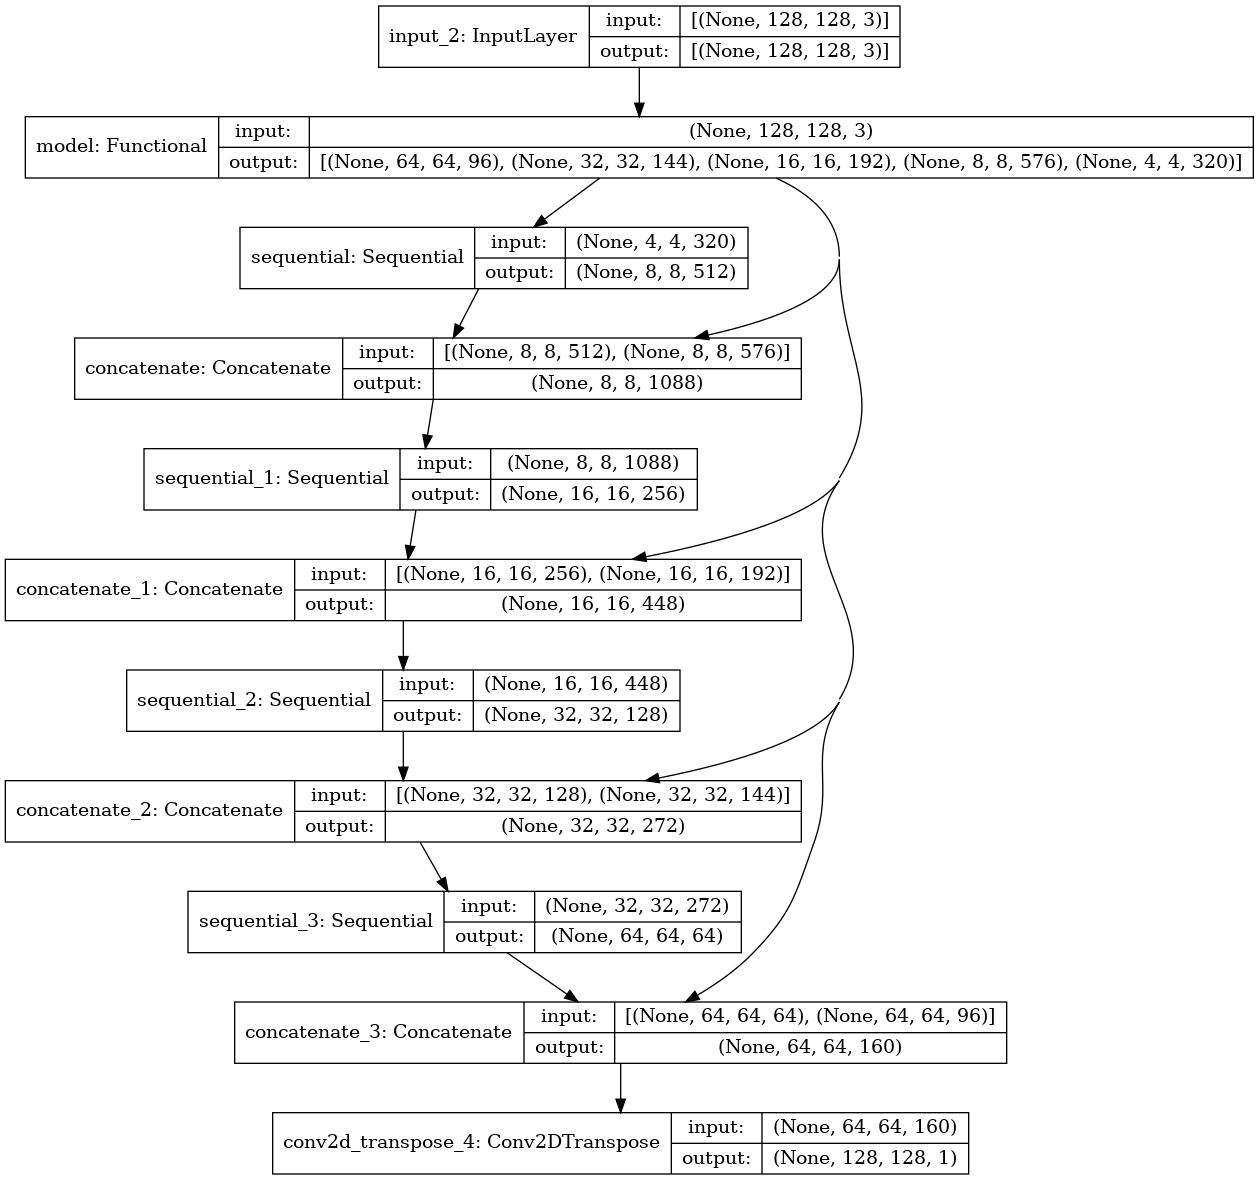

In [5]:
model = build_unet_model(output_channels=1)
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [22]:
import cv2
import matplotlib.pyplot as plt
new_image_dir = '/kaggle/input/celebamaskhq-reduced/Images'
new_mask_dir = '/kaggle/input/celebamaskhq-reduced/HeadMasks'

images = [new_image_dir +"/" + img for img in sorted(os.listdir(new_image_dir))]
masks = [new_mask_dir + "/" + img for img in sorted(os.listdir(new_mask_dir))]
X = []
Y = []
for (img_path, mask_path) in zip(images, masks):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128,128), interpolation=cv2.INTER_LANCZOS4)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128,128), interpolation=cv2.INTER_LANCZOS4)

    X.append(img)
    Y.append(mask)

In [23]:
import numpy as np
X = np.asarray(X)
Y= np.asarray(Y)
Y = np.float32(Y / 255) # normalization

In [185]:
X.shape

(4000, 128, 128, 3)

In [186]:
Y.shape

(4000, 128, 128)

In [24]:
n_train = int(len(X) * 0.75)
x_train = X[:n_train,:,:,:]
y_train=Y[:n_train,:,:]
x_test=X[n_train:,:,:,:]
y_test =Y[n_train:,:,:]

In [25]:
!nvidia-smi

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

NUM_EPOCHS = 20
model_history = model.fit(x_train, y_train,
                              epochs=NUM_EPOCHS,
                              batch_size = 64)

Sun Jan 15 21:14:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    35W / 250W |  15977MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
model.evaluate(x_test, y_test)

32/32 [==============================] - 2s 31ms/step - loss: 0.2192 - accuracy: 0.9078 - precision: 0.9471 - recall: 0.9221


[0.21915492415428162,
 0.9078064560890198,
 0.9471226334571838,
 0.9221240878105164]

In [191]:
model.save('weights.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


(1000, 128, 128, 3)
(128, 128, 3)
(128, 128)
show predictions 2


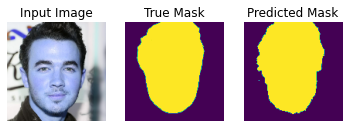

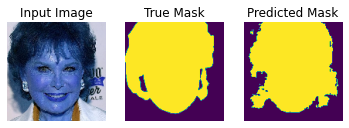

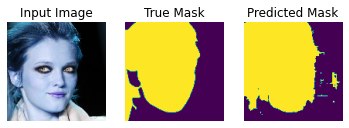

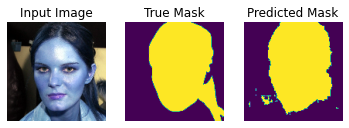

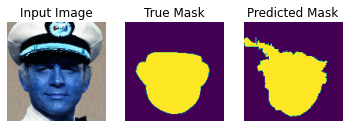

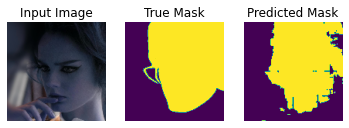

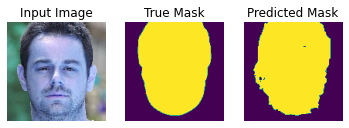

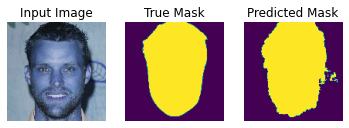

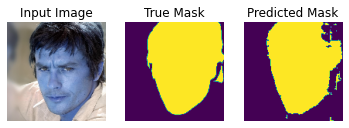

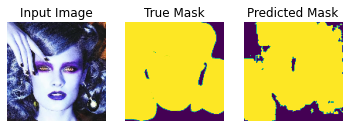

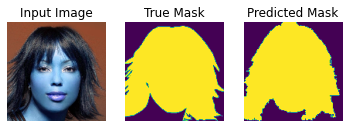

In [28]:
def display(display_list):
    title = ["Input Image", "True Mask", "Predicted Mask"]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis("off")
    plt.show()

print(x_test.shape)
print(x_test[0].shape)
print(y_test[0].shape)
def show_predictions():
    predictions = model.predict(x_test)
    i = 0
    for test_image, actual_mask, prediction in zip(x_test, y_test, predictions):
        i += 1
        prediction[prediction > 0.5] = 1
        prediction[prediction < 0.5] = 0

        display([test_image, actual_mask, prediction])
        if i > 10:
            break
            
print("show predictions 2")
show_predictions()
